# Plumber Example

Here we show the basic API of Plumber.
First, a user defines a tf.data dataset.
Second, the dataset is run long enough to get some statistics.
Third, we can injest the data emitted by Plumber to get a performance model, which we can query.
We use this same performance model for automatic graph rewrites (not shown here).

In [1]:
import tensorflow as tf

2022-02-13 00:37:33.435795: I tensorflow/core/tpu/tpu_api_dlsym_initializer.cc:116] Libtpu path is: libtpu.so


We make a dataset with casting ints to float, and then padded batching. We repeat the dataset twice.

In [2]:
def get_dataset():
    # Make a dataset with casting ints to float, and then padded batching
    # Repeat it twice
    dataset = tf.data.Dataset.range(100000)
    dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
    dataset = dataset.padded_batch(4, padded_shapes=(None,))
    dataset = dataset.repeat(2)
    options = tf.data.Options()
    options.experimental_threading.max_intra_op_parallelism = 1
    # Add Plumber output pointing to stats.pb
    options.experimental_optimization.autotune_stats_filename = "stats.pb"
    options.experimental_optimization.map_parallelization = False
    dataset = dataset.with_options(options)
    return dataset

Run it for some time...

In [3]:
ds = get_dataset()
for i in ds:
    pass

2022-02-13 00:37:34.219342: I tensorflow/stream_executor/tpu/tpu_platform_interface.cc:77] No TPU platform registered. Waiting 1 second and trying again... (4 tries left)
2022-02-13 00:37:35.219475: I tensorflow/stream_executor/tpu/tpu_platform_interface.cc:77] No TPU platform registered. Waiting 1 second and trying again... (3 tries left)
2022-02-13 00:37:36.219606: I tensorflow/stream_executor/tpu/tpu_platform_interface.cc:77] No TPU platform registered. Waiting 1 second and trying again... (2 tries left)
2022-02-13 00:37:37.219935: I tensorflow/stream_executor/tpu/tpu_platform_interface.cc:77] No TPU platform registered. Waiting 1 second and trying again... (1 tries left)
2022-02-13 00:37:38.220110: I tensorflow/stream_executor/tpu/tpu_platform_interface.cc:74] No TPU platform found.
2022-02-13 00:37:38.220924: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruction

Injest the dumped stats.pb file.

In [4]:
filename = "stats.pb"
plumber = tf.data.experimental.analysis.PlumberPerformanceModel(filename)
model = plumber.model()

Do some basic modeling. Let's visualize the model with an image.

In [5]:
model.to_graphviz("stats.dot")
recommendation = model.recommendation()

Let's use dot program to convert the .dot file to a .png.

In [6]:
!dot -Tpng stats.dot -o stats.png

Here we can see the statistics gathered by Plumber. The red Dataset is considered the bottleneck.

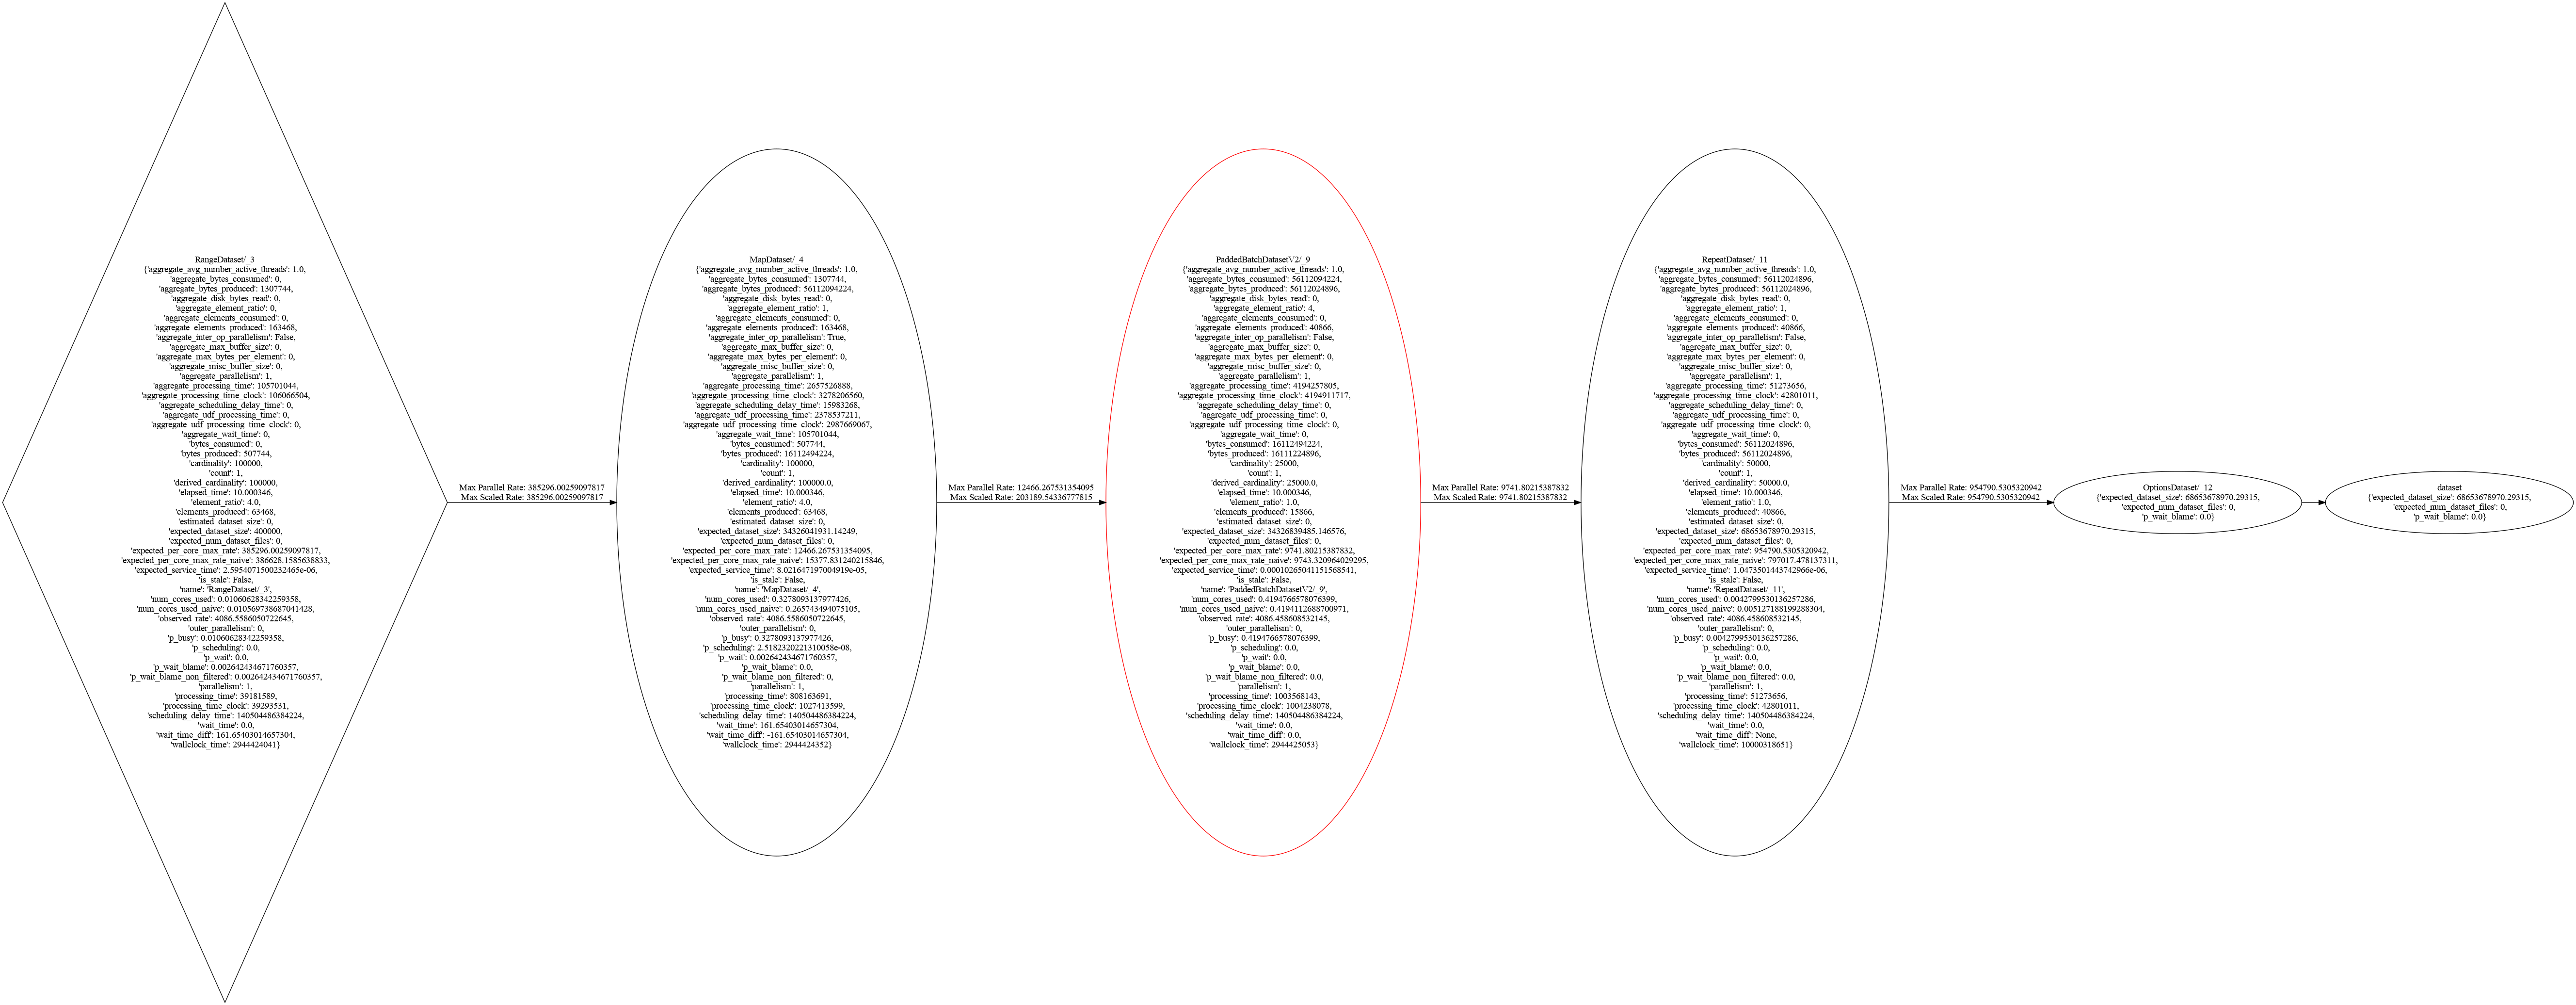

In [7]:
from IPython.display import Image
Image(filename='stats.png') 

Finally, we may want to use Plumber in other software, such as graph rewriters. We can query various model parameters using standard Python.

In [8]:
slowest_node = recommendation.bottleneck_node()
print("Slowest node: {}".format(slowest_node.name))
CPU_time_used = model.total_CPU_time()
wallclock_used = model.total_wallclock_time()
cpu_util = model.CPU_Util()
disk_util = model.Disk_Util()
print("Resource utilization: CPU Util {} ({}s CPU time,{}s wallclock time),"
      " Disk Util {}".format(cpu_util,
                        CPU_time_used,
                        wallclock_used,
                        disk_util))

Slowest node: PaddedBatchDatasetV2/_9
Resource utilization: CPU Util 0.04380323061447074 (7.008759393s CPU time,10.000346s wallclock time), Disk Util 0.0
